In [1]:
# Install required libraries
!pip install nltk --quiet
!pip install tensorflow --quiet
!pip install gradio --quiet

In [2]:
# Imports
import pandas as pd
import numpy as np
import nltk
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dropout, Dense

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
# Load dataset
df = pd.read_csv('/content/customer_support_tickets.csv', encoding='utf-8', parse_dates=['Date of Purchase'], dayfirst=True)
df = df[['Ticket Type', 'Ticket Description']].dropna()


<ipython-input-4-0f588da7015b>:2: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df = pd.read_csv('/content/customer_support_tickets.csv', encoding='utf-8', parse_dates=['Date of Purchase'], dayfirst=True)


In [6]:
# Improved text cleaning
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk # Ensure nltk is imported here if it wasn't already in this cell

# Download the required punkt_tab resource
nltk.download('punkt_tab', quiet=True)


stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r"{.*?}", "", text)
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text.lower())
    filtered = [w for w in tokens if w not in stop_words and w.isalpha()]
    return " ".join(filtered)

df['clean_text'] = df['Ticket Description'].apply(clean_text)

In [8]:
# Balance the dataset (downsample majority class)
min_class_size = df['Ticket Type'].value_counts().min()
df_balanced = pd.concat([
    resample(group, replace=False, n_samples=min_class_size, random_state=42)
    for _, group in df.groupby('Ticket Type')
])
df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


In [9]:
# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['Ticket Type'])

In [10]:
# Tokenize text
vocab_size = 5000
max_length = 100
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])
padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')


In [11]:
# Train/test split
X = padded
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
# Define the model
model = Sequential([
    Embedding(vocab_size, 128, input_length=max_length),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Train the model
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test), verbose=1)

# Evaluate
y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred, target_names=le.classes_))


Epoch 1/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.2057 - loss: 1.6115 - val_accuracy: 0.1934 - val_loss: 1.6106
Epoch 2/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2016 - loss: 1.6100 - val_accuracy: 0.2069 - val_loss: 1.6094
Epoch 3/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1913 - loss: 1.6095 - val_accuracy: 0.2069 - val_loss: 1.6094
Epoch 4/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2067 - loss: 1.6094 - val_accuracy: 0.1934 - val_loss: 1.6096
Epoch 5/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1987 - loss: 1.6097 - val_accuracy: 0.1934 - val_loss: 1.6096
Epoch 6/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2130 - loss: 1.6094 - val_accuracy: 0.1977 - val_loss: 1.6096
Epoch 7/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2038 - loss: 1.6095 - val_accuracy: 0.1977 - val_loss: 1.6096
Epoch 8/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2077 - loss: 1.6095 - val_accuracy: 0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


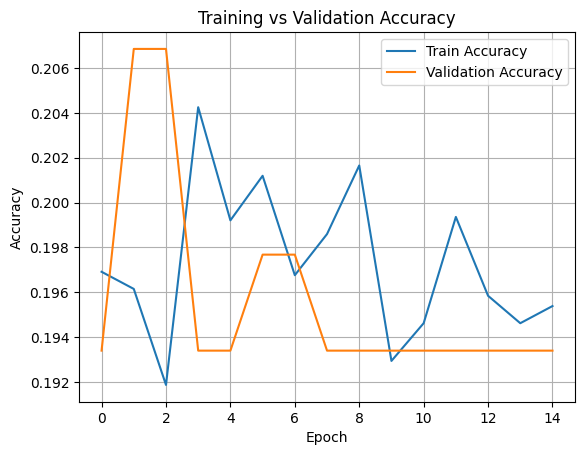

In [14]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
# Define prediction function
def predict_issue(text):
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded_seq = pad_sequences(seq, maxlen=max_length, padding='post', truncating='post')
    prediction = model.predict(padded_seq)[0]
    top_indices = prediction.argsort()[-3:][::-1]
    results = {le.inverse_transform([i])[0]: f"{prediction[i]:.2f}" for i in top_indices}
    return results


In [17]:
# Gradio interface
import gradio as gr

iface = gr.Interface(
    fn=predict_issue,
    inputs=gr.Textbox(lines=4, placeholder="Describe your issue here..."),
    outputs="label",
    title="Customer Support Chatbot",
    description="Enter your issue and the chatbot will classify it. Shows top 3 probable categories with confidence."
)

iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d181dd9ffc049fb05e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
